# **Wrangle and Analyze Data**

## Table of Contents
- [Introduction](#intro)
- [Gathering Data](#gatheringdata)
- [Asses](#asses)
- [Clean](#clean)
- [Visualizing Data](#visualize)

<a id='intro'></a>
## Introduction

Goal of this project is to gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. The dataset that will be wrangled (and analyzed and visualized) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import tweepy
from os import path
import re
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a id='gatheringdata'></a>
## Gathering Data

Data was gathered from multiple sources:
1. The WeRateDogs Twitter archive: twitter_archive_enhanced.csv provided for this project
2. The tweet image predictions: what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and will be downloaded programmatically.
3. Each tweet's entire set of JSON data in a file called tweet_json.txt aquired using tweet IDs in the WeRateDogs Twitter archive



### Load Data

#### WeRateDogs Twitter archive

In [0]:
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')

In [0]:
print(f'Twitter archive loaded into a dataframe of {df_twitter.shape[0]} rows and {df_twitter.shape[1]} columns') 

Twitter archive loaded into a dataframe of 2356 rows and 17 columns


#### Tweet image predictions

In [0]:
if not path.exists('image-predictions.tsv'):
    # Sernding HTTP/1.1 request
    url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    response = requests.get(url)
    # Write to file
    with open('image-predictions.tsv', mode ='wb') as file:
        file.write(response.content)

In [0]:
# check if file created and load
if path.exists('image-predictions.tsv'):
    df_img_preds = pd.read_csv('image-predictions.tsv', sep='\t')
    print(f'Image predictions loaded into a dataframe of {df_img_preds.shape[0]} rows and {df_img_preds.shape[1]} columns') 
else:
    print('ERROR: file doesnt exist!')

Image predictions loaded into a dataframe of 2075 rows and 12 columns


#### Tweets entire JSON data

In [0]:
# Connecting to twitter API
def ConnectToTwitterAPI(consumer_key, consumer_secret, access_token, access_secret):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth)
    return api

def ExtractDataFromApi(tweet_ids):
    # loop through them and extract json data
    tweet_data = []
    for id in tweet_ids:
        try:
            tweet = api.get_status(id, 
                                tweet_mode='extended', 
                                wait_on_rate_limit=True, 
                                Wait_on_rate_limit_notify=True)
            tweet_data.append(tweet)
        except:
            print(f'Unable to grab data for tweet id {id}')
    print(f'Data found for {len(tweet_data)} out of {df_img_preds.shape[0]} tweets')

    return tweet_data

def WriteTweetDataToJsonFile(tweet_data):
    with open('tweet-json.txt', mode = 'w') as file:
        json.dump(tweet_data, file)

def ReadTweetDataFromJsonFile(file):
    with open(file, encoding='utf-8') as json_file:
        data = json.load(json_file)
    print(f'Read {len(data)} json records from {file}')
    return data

def LoadJsonToDataFrame(json_data):
    tweets = []
    for json_tweet in json_data:
        tweets.append({
            'tweet_id' : json_tweet['id'],
            # 'favorited' : json_tweet['favorited'],
            # 'retweeted' : json_tweet['retweeted'],
            'favorite_count' : json_tweet['favorite_count'],
            'retweet_count' : json_tweet['retweet_count'],
            'followers_count' : json_tweet['user']['followers_count'],
            'friends_count' : json_tweet['user']['friends_count'],
            'listed_count' : json_tweet['user']['listed_count'],
            'statuses_count': json_tweet['user']['statuses_count']})
    df_tweets_api = pd.DataFrame(tweets, columns=['tweet_id' , 'favorite_count', 'retweet_count','followers_count','friends_count', 'listed_count', 'statuses_count'])
    
    print(f'Tweet data loaded from api into a dataframe of {df_tweets_api.shape[0]} rows and {df_tweets_api.shape[1]} columns') 
    return df_tweets_api    
        



In [0]:
if not path.exists('tweet-json.txt'):
    consumer_key = 'PNCHaJoIWwIqgmLwUN4y1eWV2'
    consumer_secret = 'S3mGnnYw90IxAVAbdVqvnnLXylkkuczs9QBaoUbGXDak9Rk99s'
    access_token = '1265046638852177922-1TpjAzlCNONthmU6NeprTV9uME4qby'
    access_secret = '3P3ccncdi6O2aqg6uHELMHFJ9QcoaAXbJFzByigj8z6UX'

    api = ConnectToTwitterAPI(consumer_key, consumer_secret, access_token, access_secret)
    # extract all the tweetid
    tweet_ids = df_twitter['tweet_id']
    tweet_data = ExtractDataFromApi(tweet_ids)
    # Write tweet data to json file
    WriteTweetDataToJsonFile(tweet_data)

# Read from json file 
json_data = ReadTweetDataFromJsonFile('tweet-json.txt')
# Load into dataframe
df_tweets_api = LoadJsonToDataFrame(json_data)

Read 2330 json records from tweet-json.txt
Tweet data loaded from api into a dataframe of 2330 rows and 7 columns


<a id='asses'></a>
## Assess

Lets start with the twitter archive loaded into dataframe 

In [0]:
# Take a look at first few rows in dataframe
df_twitter.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1710,680583894916304897,NaN,NaN,2015-12-26 03:00:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. Her tennis ball slowly rolled d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680583894...,8,10,Penny,None,None,None,None
1174,720059472081784833,NaN,NaN,2016-04-13 01:22:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charleson. He lost his plunger. Looked...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/720059472...,9,10,Charleson,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
1318,706538006853918722,NaN,NaN,2016-03-06 17:52:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Oliver (pronounced ""Ricardo""). He's a ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/706538006...,11,10,Oliver,None,None,None,None
1992,672614745925664768,NaN,NaN,2015-12-04 03:13:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Norman. Doesn't bark much. Very docile...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672614745...,6,10,Norman,None,None,pupper,None


In [0]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [0]:
df_twitter.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [0]:
df_twitter['tweet_id'].nunique()

2356

Initial observation

1.   Total 2356 tweets
2.   Incomplete columns:
    - in_reply_to_status_id
    - in_reply_to_user_id  
    - retweeted_status_id
    - retweeted_status_user_id
    - retweeted_status_timestamp
    - expanded_urls
3.   Timestame and retweeted_status_timestamp is object not of type DateTime
4.   Source column has html tags present 
5.   Name Column has invalid names such as None
6.   The last 4 columns doggo, floofer, pupper and puppo can instead be a single categorical column
7. Rating numerator and denominator dont seem to fall in valid range of values since their max values are 1776 and 170



Next, lets look at the Tweet image predictions dataframe 

In [0]:
df_img_preds.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2023,881536004380872706,https://pbs.twimg.com/ext_tw_video_thumb/88153...,1,Samoyed,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False
476,675153376133427200,https://pbs.twimg.com/media/CV6gaUUWEAAnETq.jpg,1,paper_towel,0.327957,False,mailbox,0.096027,False,seat_belt,0.034995,False
1530,789530877013393408,https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg,3,schipperke,0.363272,True,kelpie,0.197021,True,Norwegian_elkhound,0.151024,True
1533,789986466051088384,https://pbs.twimg.com/media/CvaYgDOWgAEfjls.jpg,1,tub,0.479477,False,bathtub,0.325106,False,golden_retriever,0.078530,True
1909,852912242202992640,https://pbs.twimg.com/media/C9YnKK3VoAAxn1E.jpg,1,Great_Dane,0.783765,True,Rhodesian_ridgeback,0.114147,True,English_foxhound,0.046440,True


In [0]:
df_img_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Initial Observation:

This dataframe looks complete for the most part and has the correct datatypes for each column. Key here would be how we use it.

1. Inconsistency, the prediction columns p1, p2, p3 do not follow similar case format and are seperated by an underscore. 
2. This data can be combined with tweeter archive dataframe

Finally, the tweets api dataframe

In [0]:
df_tweets_api.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count
0,892420643555336193,36230,7711,8785083,16,5536,12252
1,892177421306343426,31252,5699,8785083,16,5536,12252
2,891815181378084864,23529,3779,8785083,16,5536,12252
3,891689557279858688,39535,7875,8785083,16,5536,12252
4,891327558926688256,37745,8484,8785083,16,5536,12252


In [0]:
df_tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tweet_id         2330 non-null   int64
 1   favorite_count   2330 non-null   int64
 2   retweet_count    2330 non-null   int64
 3   followers_count  2330 non-null   int64
 4   friends_count    2330 non-null   int64
 5   listed_count     2330 non-null   int64
 6   statuses_count   2330 non-null   int64
dtypes: int64(7)
memory usage: 127.5 KB


In [0]:
df_tweets_api.describe()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,listed_count,statuses_count
count,2.330000e+03,2330.000000,2330.000000,2.330000e+03,2330.0,2330.000000,2330.0
mean,7.419357e+17,7568.380687,2706.056223,8.785103e+06,16.0,5536.238197,12252.0
std,6.823308e+16,11746.852715,4575.752360,6.318969e+01,0.0,0.426072,0.0
min,6.660209e+17,0.000000,1.000000,8.785082e+06,16.0,5536.000000,12252.0
25%,6.782926e+17,1318.250000,547.000000,8.785084e+06,16.0,5536.000000,12252.0
50%,7.183508e+17,3289.000000,1269.500000,8.785096e+06,16.0,5536.000000,12252.0
75%,7.986712e+17,9264.000000,3146.750000,8.785101e+06,16.0,5536.000000,12252.0
max,8.924206e+17,156352.000000,77862.000000,8.785742e+06,16.0,5537.000000,12252.0


<a id='clean'></a>
# Clean

In [0]:
df_twitter_clean = df_twitter.copy()
df_img_preds_clean = df_img_preds.copy()
df_tweets_api_clean = df_tweets_api.copy() 

## Quality Issue 1

**Define:** Convert tweet_id from integer to string

**Code:** Use astype() function to set a new type to exisiting column

In [0]:
df_twitter_clean['tweet_id'] = df_twitter_clean['tweet_id'].astype(str)
df_img_preds_clean['tweet_id'] = df_img_preds_clean['tweet_id'].astype(str)
df_tweets_api_clean['tweet_id'] = df_tweets_api_clean['tweet_id'].astype(str)

**Test:** Review dataframe information for datatype

In [0]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   object 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## Quality Issue 2

**Define:** Remove retweets

We acheive this by removing any column where retweet status id is not null

**Code:** Find all indices where retweeted_status_id is NaN

In [0]:
df_twitter_clean = df_twitter_clean[np.isnan(df_twitter_clean.retweeted_status_id)]

**Test:** We will verify the DataFrame information to check if all retweeted variables non-null count should be 0

In [0]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   object 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

## Tidiness Issue 1

**Define:** Consolidating dog type to 1 column

Dog types are: 
doggo', 'floofer', 'pupper', 'puppo'

These columns were originally created by extracting from the text associated with each tweet

**Code:** Extract the dog type from each inidivdual column and populate the new dog_type column

In [0]:
dog_type = []
for index, row in df_twitter_clean.iterrows():
    if row['doggo'] == 'doggo':
        dog_type.append('doggo')
    elif row['pupper'] == 'pupper':
        dog_type.append('pupper')
    elif row['floofer'] == 'floofer':
        dog_type.append('floofer')
    elif row['puppo'] == 'puppo':
        dog_type.append('puppo')
    else:
        dog_type.append('None')
df_twitter_clean['dog_type'] = dog_type

**Test:** Verify if new column is created and matches the previous inidvidual dog type columns

In [0]:
df_twitter_clean['dog_type'].value_counts()

None       1831
pupper      224
doggo        87
puppo        24
floofer       9
Name: dog_type, dtype: int64

In [0]:
df_twitter_clean[['doggo', 'floofer', 'pupper', 'puppo', 'dog_type']].sample(10)

,doggo,floofer,pupper,puppo,dog_type
173,None,None,None,None,None
270,None,None,None,None,None
658,None,None,None,None,None
24,None,None,None,None,None
576,doggo,None,None,None,doggo
862,None,None,None,None,None
2066,None,None,None,None,None
2087,None,None,None,None,None
1297,None,None,None,None,None
1912,None,None,None,None,None


## Quality Issue 3
**Define:** Remove unwanted columns

Since we removed all rows which were retweets, we can remove columns relating to retweet as well as others which dont think are relevant

**Code:** A this point we can drop these columns as they serve no purpose.

In [0]:
columns_to_drop = ['retweeted_status_id', 
                   'retweeted_status_user_id', 
                   'retweeted_status_timestamp',
                   'in_reply_to_status_id', 
                   'in_reply_to_user_id',
                   'doggo', 
                   'floofer', 
                   'pupper', 
                   'puppo']
df_twitter_clean = df_twitter_clean.drop(columns_to_drop, axis=1)

**Test:** Lets take a look at the dataframe once again and what we are left with now

In [0]:
df_twitter_clean.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None


In [0]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   object
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                2175 non-null   object
 8   dog_type            2175 non-null   object
dtypes: int64(2), object(7)
memory usage: 169.9+ KB


## Quality Issue 4

**Define:** Convert timestamp to datetime format

**Code:** Use pandas to_datatime() function

In [0]:
df_twitter_clean['timestamp'].sample(5)

2181    2015-11-24 03:29:51 +0000
1854    2015-12-12 04:35:48 +0000
226     2017-04-03 00:16:10 +0000
1083    2016-06-03 01:07:16 +0000
1376    2016-02-22 16:27:58 +0000
Name: timestamp, dtype: object

First we would need to clean up the format so it can be accepted by the function

In [0]:
# test
df_twitter_clean.sample(1)['timestamp'].str.slice(start=0, stop=-6)

150    2017-05-12 16:05:02
Name: timestamp, dtype: object

In [0]:
# apply
df_twitter_clean['timestamp'] = df_twitter_clean['timestamp'].str.slice(start=0, stop=-6)
df_twitter_clean['timestamp'] = pd.to_datetime(df_twitter_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")

**Test:** lets take a look at the dataframe information if the change has been applied. we expect to see the DateTime as the datatype for timestamp column

In [0]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2175 non-null   object        
 1   timestamp           2175 non-null   datetime64[ns]
 2   source              2175 non-null   object        
 3   text                2175 non-null   object        
 4   expanded_urls       2117 non-null   object        
 5   rating_numerator    2175 non-null   int64         
 6   rating_denominator  2175 non-null   int64         
 7   name                2175 non-null   object        
 8   dog_type            2175 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 169.9+ KB


## Quality Issue 5

**Define:** Transform dog names to match same case preference 

**Code:** We use regular expression to capitalize the first letter in all names

In [0]:
df_twitter_clean.name = df_twitter_clean.name.str.replace('^[a-z]+', 'None')

**Test:** Verify a random sample to check if the names appear correct now

In [0]:
df_twitter_clean.sample(10)['name']

417      Paisley
2095     Vincent
988         None
367        Alfie
1047        Beya
2351        None
849        Angel
1348    Ralphson
1262       Tater
916       Oliver
Name: name, dtype: object

## Quality Issue 6

**Define**: Remove HTML tags from source column

**Code**: Use regular expression to extract the html tag content

In [0]:
source_str = df_twitter_clean.sample(1)['source'].iloc[0]
source_modified = re.findall(r'>(.*)<', df_twitter_clean.sample(1)['source'].iloc[0])[0]
print(f'Before: {source_str}')
print(f'After: {source_modified}')

Before: <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
After: Twitter for iPhone


In [0]:
# apply to entire column
df_twitter_clean['source'] = df_twitter_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

**Test:** Verify the dataframe sorce column

In [0]:
df_twitter_clean.sample(10)['source']

909     Twitter for iPhone
178     Twitter for iPhone
2187    Twitter for iPhone
2192    Twitter for iPhone
153     Twitter for iPhone
958     Twitter for iPhone
918     Twitter for iPhone
1077    Twitter for iPhone
1873    Twitter for iPhone
352     Twitter Web Client
Name: source, dtype: object

In [0]:
df_twitter_clean['source'].value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

## Quality Issue 7

**Define:** Fix ratings numerator and denominator

**Code:** First lets change the data format for numerator and denominator to be a float




In [0]:
df_twitter_clean['rating_numerator'] = df_twitter_clean['rating_numerator'].astype(float)
df_twitter_clean['rating_denominator'] = df_twitter_clean['rating_denominator'].astype(float)

Next, we will search the text column for numerators with decimal point

In [0]:
# have a look at one of the text fields to create regex pattern
temp_text = df_twitter_clean.sample(1)['text'].iloc[0]
print(temp_text)

@TheEllenShow I'm not sure if you know this but that doggo right there is a 12/10


In [0]:
# first we try to searh without a decimal point since that is more common
result = re.search('\d+\/\d+', temp_text)
print(result)

<_sre.SRE_Match object; span=(76, 81), match='12/10'>


In [0]:
bool(result)

True

In [0]:
result.group()

'12/10'

In [0]:
# Search for the index of rows with decimal in ratings numerator
decimal_rating_index=[]
decimal_rating_values=[]
for index, row in df_twitter_clean.iterrows():
    text = row['text']
    result = re.search('\d+\.\d+\/\d+', text)
    if bool(result):
        decimal_rating_index.append(index)
        decimal_rating_values.append(result.group())
        print(index, ': ', result.group(), ', ', text)

45 :  13.5/10 ,  This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
695 :  9.75/10 ,  This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
763 :  11.27/10 ,  This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
1689 :  9.5/10 ,  I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace
1712 :  11.26/10 ,  Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD


In [0]:
for i, index in enumerate(decimal_rating_index):
    num_splits = decimal_rating_values[i].split('/')
    print(num_splits)
    df_twitter_clean.loc[index,'rating_numerator'] = float(num_splits[0])
    df_twitter_clean.loc[index,'rating_denominator'] = float(num_splits[1])

['13.5', '10']
['9.75', '10']
['11.27', '10']
['9.5', '10']
['11.26', '10']


In [0]:
float(num_splits[1])

10.0

**Test:** Verify numerator and denominator values in the rows affected

In [0]:
for index in decimal_rating_index:
    print(df_twitter_clean.loc[index])
    print('-----------------------------------------------------------------------')

tweet_id                                             883482846933004288
timestamp                                           2017-07-08 00:28:19
source                                               Twitter for iPhone
text                  This is Bella. She hopes her smile made you sm...
expanded_urls         https://twitter.com/dog_rates/status/883482846...
rating_numerator                                                   13.5
rating_denominator                                                   10
name                                                              Bella
dog_type                                                           None
Name: 45, dtype: object
-----------------------------------------------------------------------
tweet_id                                             786709082849828864
timestamp                                           2016-10-13 23:23:56
source                                               Twitter for iPhone
text                  This is Logan, the

In [0]:
df_twitter_clean.describe()

,rating_numerator,rating_denominator
count,2175.000000,2175.000000
mean,13.177140,10.492874
std,47.705088,7.019084
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [0]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2175 non-null   object        
 1   timestamp           2175 non-null   datetime64[ns]
 2   source              2175 non-null   object        
 3   text                2175 non-null   object        
 4   expanded_urls       2117 non-null   object        
 5   rating_numerator    2175 non-null   float64       
 6   rating_denominator  2175 non-null   float64       
 7   name                2175 non-null   object        
 8   dog_type            2175 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 249.9+ KB


## Quality Issue 8

**Define:** Create a rating column using the numerator and denominator so it is easy to compare one dog against another irrespective of their rating scale

**Code:** We devide numerator with denominator and assign to new column

In [0]:
df_twitter_clean['rating'] = df_twitter_clean['rating_numerator'] / df_twitter_clean['rating_denominator']

**Test:** Sample the dataframe and view the new column

In [0]:
df_twitter_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,rating
1122,730573383004487680,2016-05-12 01:40:42,Twitter for iPhone,This is Rooney. He can't comprehend glass. 10/...,https://twitter.com/dog_rates/status/730573383...,10.0,10.0,Rooney,pupper,1.0
253,844704788403113984,2017-03-23 00:18:10,Twitter for iPhone,This is Luna. It's her first time outside and ...,https://twitter.com/dog_rates/status/844704788...,13.0,10.0,Luna,None,1.3
360,829861396166877184,2017-02-10 01:15:49,Twitter for iPhone,This is Mia. She already knows she's a good do...,https://twitter.com/dog_rates/status/829861396...,12.0,10.0,Mia,None,1.2
426,821407182352777218,2017-01-17 17:21:47,Twitter for iPhone,This is Sundance. He's a doggo drummer. Even s...,https://twitter.com/dog_rates/status/821407182...,14.0,10.0,Sundance,doggo,1.4
378,827933404142436356,2017-02-04 17:34:40,Twitter for iPhone,This is Kona. Yesterday she stopped by the dep...,https://twitter.com/dog_rates/status/827933404...,12.0,10.0,Kona,pupper,1.2


## Quality Issue 9
**Define:** Add column dog_breed to predictions data frame based on predictions 

**Code:** Consolidate the predictions and their repective probablitiy to one dog_breed column

In [0]:
dog_breed = []
for i, row in df_img_preds_clean.iterrows():
    if row['p1_dog']:
        dog_breed.append(row.p1)
    elif row['p2_dog']:
        dog_breed.append(row.p2)
    elif row['p3_dog']:
        dog_breed.append(row.p3)
    else:
        dog_breed.append('None')
        
df_img_preds_clean['dog_breed'] = dog_breed

**Test**: Sample the dataframe as well its summary information to look at the newly created column

In [0]:
df_img_preds_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
1887,847971574464610304,https://pbs.twimg.com/media/C8SZH1EWAAAIRRF.jpg,1,coffee_mug,0.633652,False,cup,0.273392,False,toilet_tissue,0.066656,False,None
1929,858471635011153920,https://pbs.twimg.com/media/C-nnZBdXkAAB-wg.jpg,1,Pembroke,0.987407,True,Cardigan,0.008723,True,basenji,0.003424,True,Pembroke
1516,786963064373534720,https://pbs.twimg.com/media/Cuvau3MW8AAxaRv.jpg,1,golden_retriever,0.915303,True,Saluki,0.046213,True,Labrador_retriever,0.037504,True,golden_retriever
1815,833826103416520705,https://pbs.twimg.com/media/C5JYaYoVYAAcEQw.jpg,1,Chihuahua,0.438054,True,kelpie,0.149706,True,Pembroke,0.096480,True,Chihuahua
190,669393256313184256,https://pbs.twimg.com/media/CUopnHPVEAAcL2o.jpg,1,cocker_spaniel,0.359843,True,Blenheim_spaniel,0.139519,True,toy_poodle,0.132746,True,cocker_spaniel


In [0]:
df_img_preds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   2075 non-null   object 
 1   jpg_url    2075 non-null   object 
 2   img_num    2075 non-null   int64  
 3   p1         2075 non-null   object 
 4   p1_conf    2075 non-null   float64
 5   p1_dog     2075 non-null   bool   
 6   p2         2075 non-null   object 
 7   p2_conf    2075 non-null   float64
 8   p2_dog     2075 non-null   bool   
 9   p3         2075 non-null   object 
 10  p3_conf    2075 non-null   float64
 11  p3_dog     2075 non-null   bool   
 12  dog_breed  2075 non-null   object 
dtypes: bool(3), float64(3), int64(1), object(6)
memory usage: 168.3+ KB


## Tidiness Issue 2

**Define:** Drop unwanted columns from df_img_preds and merge with df_twitter_clean

Droping unwanted columns

In [0]:
df_img_preds_clean.drop(columns=['img_num'], inplace=True)

**Code**: Use pandas merge function on tweet_id column

In [0]:
df_tweets_dogs = df_twitter_clean.merge(df_img_preds_clean, on='tweet_id', how='inner')

**Test**: Sample the dataframe and ensure all columns look correctly merged

In [0]:
df_tweets_dogs.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,rating,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
1036,705591895322394625,2016-03-04 03:13:11,Twitter for iPhone,"""Ma'am, for the last time, I'm not authorized ...",https://twitter.com/dog_rates/status/705591895...,11.0,10.0,None,None,1.1,https://pbs.twimg.com/media/CcrEFQdUcAA7CJf.jpg,basenji,0.877207,True,Italian_greyhound,0.047854,True,miniature_pinscher,0.035638,True,basenji
1461,676936541936185344,2015-12-16 01:27:03,Twitter for iPhone,Here we see a rare pouched pupper. Ample stora...,https://twitter.com/dog_rates/status/676936541...,8.0,10.0,None,pupper,0.8,https://pbs.twimg.com/media/CWT2MUgWIAECWig.jpg,Chesapeake_Bay_retriever,0.545286,True,Norwegian_elkhound,0.081482,True,space_heater,0.047391,False,Chesapeake_Bay_retriever
870,727524757080539137,2016-05-03 15:46:33,Twitter for iPhone,This pupper had to undergo emergency haircut s...,https://twitter.com/dog_rates/status/727524757...,10.0,10.0,None,pupper,1.0,https://pbs.twimg.com/media/Chiv6BAW4AAiQvH.jpg,Pomeranian,0.958834,True,Chihuahua,0.024099,True,chow,0.003941,True,Pomeranian
1041,705223444686888960,2016-03-03 02:49:06,Twitter for iPhone,This is Bode. He's a heavy sleeper. 9/10 https...,https://twitter.com/dog_rates/status/705223444...,9.0,10.0,Bode,None,0.9,https://pbs.twimg.com/media/Ccl0-HVVAAAf8aK.jpg,Egyptian_cat,0.090508,False,Chesapeake_Bay_retriever,0.077373,True,Mexican_hairless,0.049472,True,Chesapeake_Bay_retriever
1784,670003130994700288,2015-11-26 22:16:09,Twitter for iPhone,This is Raphael. He is a Baskerville Conquista...,https://twitter.com/dog_rates/status/670003130...,10.0,10.0,Raphael,None,1.0,https://pbs.twimg.com/media/CUxUSuaW4AAdQzv.jpg,beagle,0.375313,True,Saint_Bernard,0.174911,True,English_foxhound,0.115888,True,beagle


In [0]:
df_tweets_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1994 non-null   object        
 1   timestamp           1994 non-null   datetime64[ns]
 2   source              1994 non-null   object        
 3   text                1994 non-null   object        
 4   expanded_urls       1994 non-null   object        
 5   rating_numerator    1994 non-null   float64       
 6   rating_denominator  1994 non-null   float64       
 7   name                1994 non-null   object        
 8   dog_type            1994 non-null   object        
 9   rating              1994 non-null   float64       
 10  jpg_url             1994 non-null   object        
 11  p1                  1994 non-null   object        
 12  p1_conf             1994 non-null   float64       
 13  p1_dog              1994 non-null   bool        

# Storing Data

In [0]:
# storing the dataframe to a csv file
df_tweets_dogs.to_csv('df_tweets_dogs.csv', encoding='utf-8', index=False)

<a id='visualize'></a>
# Visualizing Data 

## Visualization 1

Total number of tweet over time

In [0]:
# first begin by grouping the data monthly
df_monthly = df_tweets_dogs.groupby(pd.Grouper(key = 'timestamp', freq = "M")).count().reset_index()
# Review the new dataframe
df_monthly.head()

,timestamp,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,rating,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
0,2015-11-30,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296
1,2015-12-31,367,367,367,367,367,367,367,367,367,367,367,367,367,367,367,367,367,367,367,367
2,2016-01-31,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169
3,2016-02-29,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111
4,2016-03-31,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120


In [0]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           22 non-null     datetime64[ns]
 1   tweet_id            22 non-null     int64         
 2   source              22 non-null     int64         
 3   text                22 non-null     int64         
 4   expanded_urls       22 non-null     int64         
 5   rating_numerator    22 non-null     int64         
 6   rating_denominator  22 non-null     int64         
 7   name                22 non-null     int64         
 8   dog_type            22 non-null     int64         
 9   rating              22 non-null     int64         
 10  jpg_url             22 non-null     int64         
 11  p1                  22 non-null     int64         
 12  p1_conf             22 non-null     int64         
 13  p1_dog              22 non-null     int64         
 

Text(0, 0.5, 'Twwet Count')

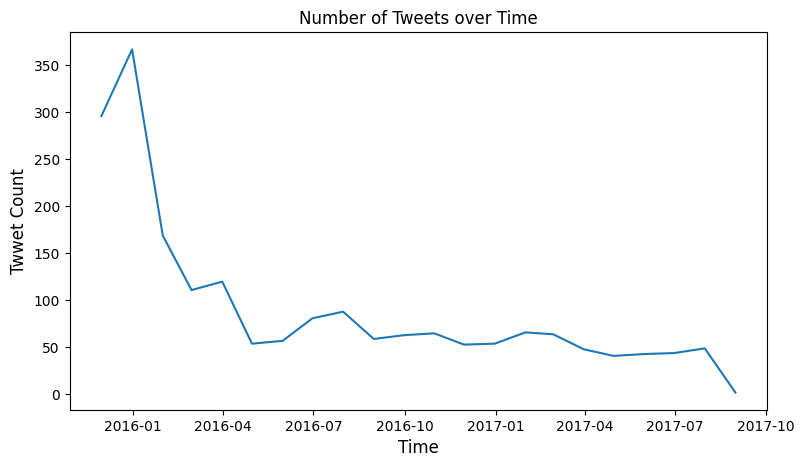

In [0]:
plt.figure(figsize=(9,5), dpi = 100)
plt.plot(df_monthly.timestamp,df_monthly.tweet_id)
plt.title('Number of Tweets over Time')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Twwet Count', fontsize=12)

Overall, there is a downward trend in number of tweets per month. There are few times when an increase in monthly tweets was observed. This seemed to happen between 2016-04 to 2016-10. A plausible reason for this decline could be due to emergence of new social media platforms.

## Visualization 2

Most popular Dog Breeds

In [0]:
# group by dog breeds and only consider ones which have a count greater than 20
df_dog_breed = df_tweets_dogs.groupby('dog_breed').filter(lambda x: len(x) >= 20)

df_dog_breed.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,rating,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,1.3,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,Chihuahua
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,1.3,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,Labrador_retriever
5,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,None,None,1.3,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,Chesapeake_Bay_retriever


In [0]:
dog_breed_counts = df_dog_breed['dog_breed'].value_counts()
dog_breed_counts.drop(index='None', inplace=True)
dog_breed_counts

golden_retriever             158
Labrador_retriever           108
Pembroke                      95
Chihuahua                     91
pug                           62
toy_poodle                    51
chow                          48
Pomeranian                    42
Samoyed                       42
malamute                      33
French_bulldog                31
Chesapeake_Bay_retriever      31
cocker_spaniel                30
miniature_pinscher            25
Eskimo_dog                    22
Staffordshire_bullterrier     21
German_shepherd               21
Cardigan                      21
beagle                        20
Siberian_husky                20
Shih-Tzu                      20
Name: dog_breed, dtype: int64

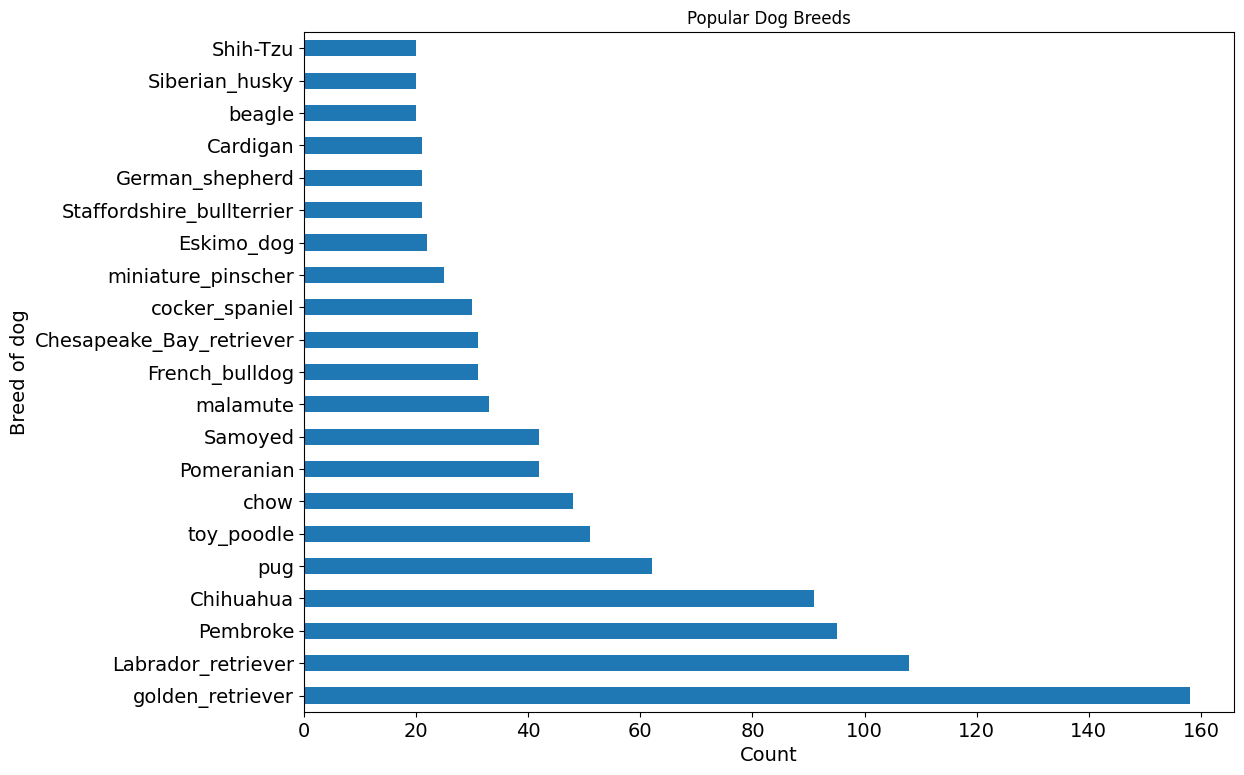

In [0]:
plt.figure(figsize=(12,9), dpi = 100)

dog_breed_counts.plot(kind = 'barh', fontsize=14)
plt.title('Popular Dog Breeds')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Breed of dog', fontsize=14);

fig = plt.gcf() 
fig.savefig('Popular_Dog_Breeds.png',bbox_inches='tight');

Golden retrievers are by far the most popular breed followed by Labrador retriever and Pembroke. This is based on the number of times each dog was tweeted about.

## Visualization 3



Ratings Distribution

In [0]:
df_tweets_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1994 non-null   object        
 1   timestamp           1994 non-null   datetime64[ns]
 2   source              1994 non-null   object        
 3   text                1994 non-null   object        
 4   expanded_urls       1994 non-null   object        
 5   rating_numerator    1994 non-null   float64       
 6   rating_denominator  1994 non-null   float64       
 7   name                1994 non-null   object        
 8   dog_type            1994 non-null   object        
 9   rating              1994 non-null   float64       
 10  jpg_url             1994 non-null   object        
 11  p1                  1994 non-null   object        
 12  p1_conf             1994 non-null   float64       
 13  p1_dog              1994 non-null   bool        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


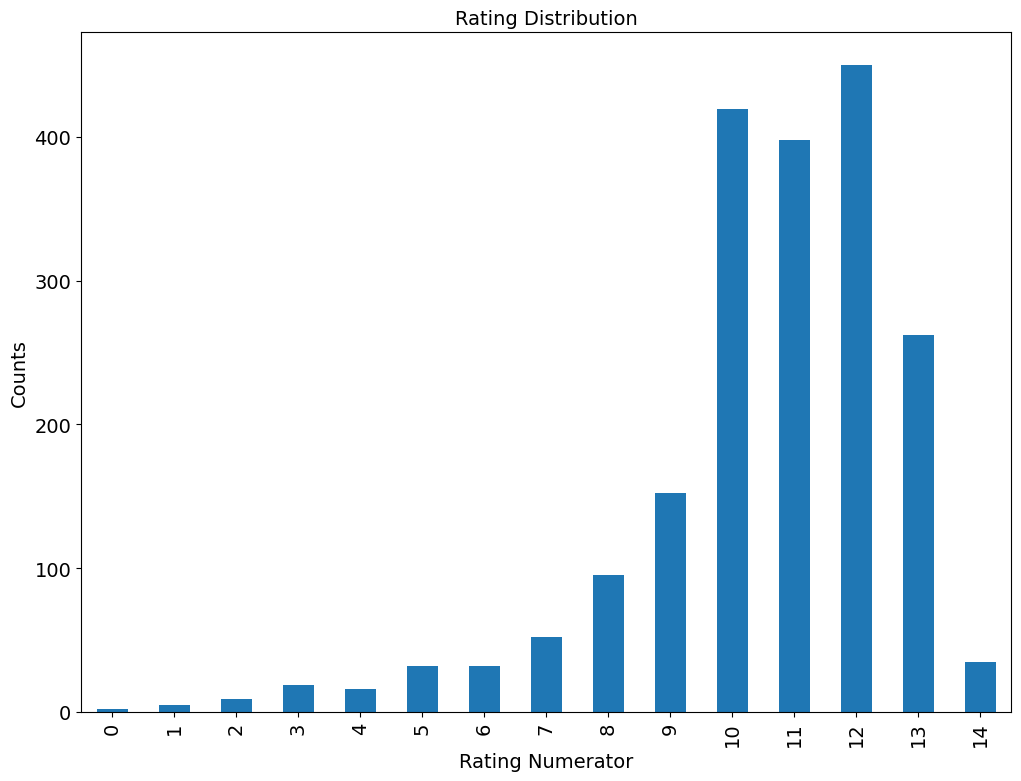

In [0]:
df_tweets_rating = df_tweets_dogs.query('rating_numerator <= 14');
df_tweets_rating['rating_numerator'] = df_tweets_rating['rating_numerator'].astype('int');
rating_counts = df_tweets_rating.groupby(['rating_numerator']).count()['tweet_id'];
plt.figure(figsize=(12,9), dpi = 100);
rating_counts.plot(kind='bar', fontsize=14);
plt.xlabel('Rating Numerator', fontsize=14);
plt.ylabel('Counts', fontsize=14);
plt.title('Rating Distribution', fontsize=14);

plt.savefig('common_ratings.png')

The distribution of dog ratings numerator seems to be skewed to the right. Once again this is to be expected as dogs who are popular or have higher ratings are the ones who are frequently tweeted about.

## Visualization 4

Most Common Dog Name

In [0]:
name_counts= df_tweets_dogs['name'].value_counts()
name_counts = name_counts[:10]
name_counts.drop(index='None', inplace=True)
name_counts

Charlie    11
Oliver     10
Lucy       10
Cooper     10
Tucker      9
Penny       9
Winston     8
Sadie       8
Lola        7
Name: name, dtype: int64

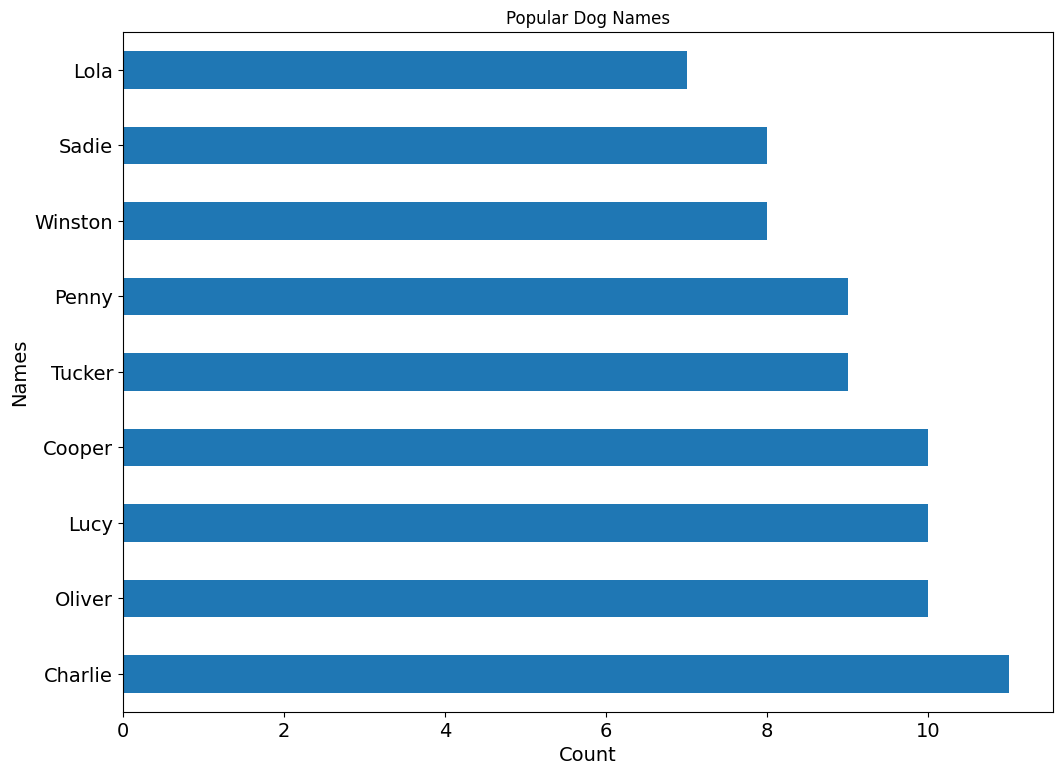

In [0]:
plt.figure(figsize=(12,9), dpi = 100)
name_counts.plot(kind = 'barh', fontsize=14)
plt.title('Popular Dog Names')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Names', fontsize=14);

fig = plt.gcf() 
fig.savefig('Popular_Dog_Names.png',bbox_inches='tight');

It is quite interesting to observe the most common names of dogs being tweeted. The top 10 choices are pretty close with not much differentiate between them in terms of counts. One would have assumes certain names are way more common then others. But data shows that there is plenty of variety when it comes to name choice.

## Visualization 5

Explore the relationship between Retweets and Likes

In [0]:
df_tweets_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2330 non-null   object
 1   favorite_count   2330 non-null   int64 
 2   retweet_count    2330 non-null   int64 
 3   followers_count  2330 non-null   int64 
 4   friends_count    2330 non-null   int64 
 5   listed_count     2330 non-null   int64 
 6   statuses_count   2330 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 127.5+ KB


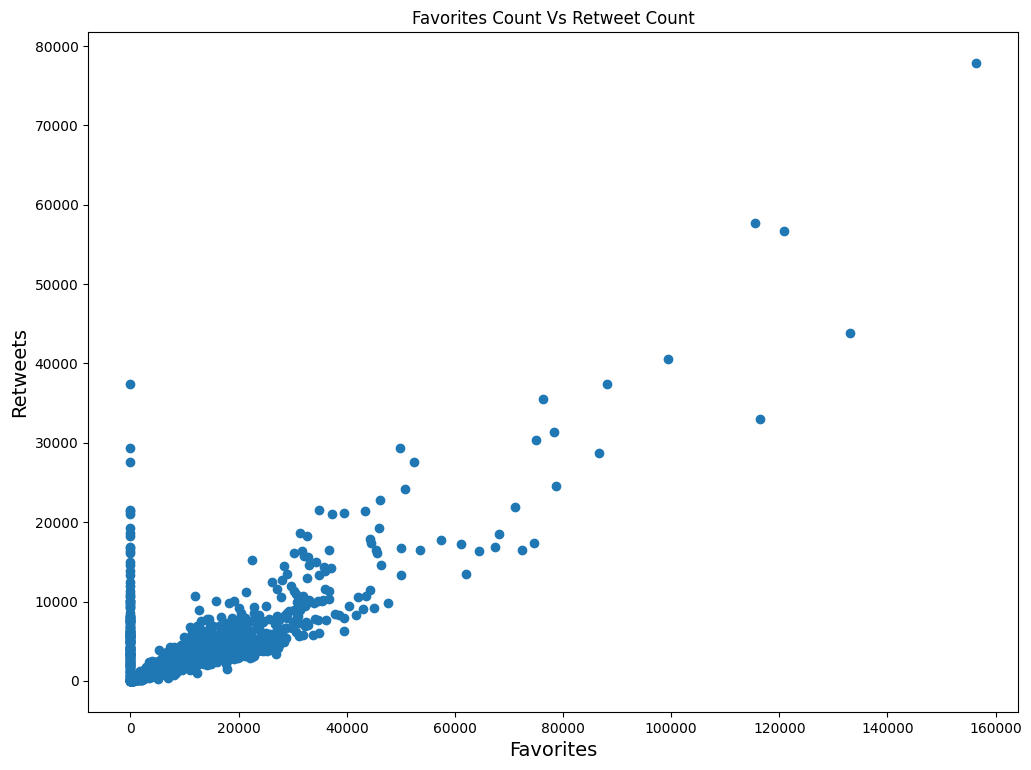

In [0]:
plt.figure(figsize=(12,9), dpi = 100)
plt.scatter(x=df_tweets_api_clean['favorite_count'],y=df_tweets_api_clean['retweet_count'])
plt.title('Favorites Count Vs Retweet Count')
plt.xlabel('Favorites', fontsize=14)
plt.ylabel('Retweets', fontsize=14);

fig = plt.gcf() 
fig.savefig('Favorites_Retweets.png',bbox_inches='tight');

We observe a strong positive trend between retweets count and favorite(like) counts. This is to be expected as most people who favorite a tweet tend to retweet it.